# Short Column Experiment from Max's paper

### First define the functions

In [1]:
import sys
sys.path.append("../")

# Module containing MFMC source code
from mfmc import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

rng = np.random.default_rng(6)  #for reproducibility


def shortcolFOM(param):
    b = param[:, 0]
    h = param[:, 1]
    P = param[:, 2]
    M = param[:, 3]
    Y = param[:, 4]
    return 1 - 4*M / (b*(h**2)*Y) - (P/(b*h*Y))**2

def shortcolROM1(param):
    b = param[:, 0]
    h = param[:, 1]
    P = param[:, 2]
    M = param[:, 3]
    Y = param[:, 4]
    return 1 - 3.8*M / (b*(h**2)*Y) - ((P*(1+(M-2000)/4000))/(b*h*Y))**2
    
def shortcolROM2(param):
    b = param[:, 0]
    h = param[:, 1]
    P = param[:, 2]
    M = param[:, 3]
    Y = param[:, 4]
    return 1 - M / (b*(h**2)*Y) - (P/(b*h*Y))**2

def shortcolROM3(param):
    b = param[:, 0]
    h = param[:, 1]
    P = param[:, 2]
    M = param[:, 3]
    Y = param[:, 4]
    return 1 - M / (b*(h**2)*Y) - (P*(1+M)/(b*h*Y))**2

def shortcolROM4(param):
    b = param[:, 0]
    h = param[:, 1]
    P = param[:, 2]
    M = param[:, 3]
    Y = param[:, 4]
    return 1 - M / (b*(h**2)*Y) - (P*(1+M)/(h*Y))**2

def drawSamples(M):
#     rng = np.random.default_rng(np.random.get_state()[1])  #for reproducibility
    b = rng.random(M)*(15 - 5) + 5
    h = rng.random(M)*(25 - 15) + 15
    P = rng.normal(0,1,M)*100 + 500;
    Mo = rng.normal(0,1,M)*400 + 2000;
    Y = np.exp(rng.normal(0,1,M)*0.5 + 5)  #z_3
    if(M < 1):
        param = []
        return
    return np.vstack([b, h, P, Mo, Y]).T

ModuleNotFoundError: No module named 'numpy'

### Compute correlations and run model selection

In [ ]:
modelList = np.array([shortcolFOM, shortcolROM1,
             shortcolROM4, shortcolROM3, shortcolROM2])

N = 1000  #number of samples for corr/var estimation
mu = drawSamples(N)
# eval models and store in matrix X
X = np.zeros((N, len(modelList)))
for i in range(len(modelList)):
    X[:, i] = modelList[i](mu)

# assign costs (replace with actual time measurements)
w = np.array([100, 50, 20, 10, 5])

print(np.corrcoef(X.T))

bestSet, bestV, vMC = optimalOrderCorr(X, w, 1000, 1)
modelList = modelList[bestSet]
w = w[bestSet]
X = X[:, bestSet]
print(f'selected models {bestSet}')

[[1.         0.99977686 0.72391378 0.83131961 0.99313996]
 [0.99977686 1.         0.73010878 0.83828667 0.99248006]
 [0.72391378 0.73010878 1.         0.82577333 0.74426339]
 [0.83131961 0.83828667 0.82577333 1.         0.86923804]
 [0.99313996 0.99248006 0.74426339 0.86923804 1.        ]]
[0] has variance 2.6289634295337027e-05
[0 1] has variance 1.4716148861768845e-05
[0 2] has variance 2.7011415747108685e-05
[0 3] has variance 1.762032738631024e-05
[0 4] has variance 3.021311960901512e-06
[0 1 2] has variance 1.9345994510523343e-05
[0 1 3] has variance 1.267273429825011e-05
[0 1 4] has variance 2.8061270707935575e-06
[0 3 2] has variance 2.6753473483486176e-05
[0 4 2] is not feasible
[0 4 3] has variance 6.60704897607443e-06
[0 1 3 2] has variance 2.100958610484646e-05
[0 1 4 2] is not feasible
[0 1 4 3] has variance 6.452619107417241e-06
[0 4 3 2] is not feasible
[0 1 4 3 2] is not feasible
selected models [0 1 4]


### Run MFMC (both versions) and MC

In [ ]:
nrRuns = 1000  #average of nrRuns runs
pList = w[0]*np.array([2**k for k in range(1,7)])


# MODIFIED MFMC

# estimate mean of output
yMean = np.zeros((len(pList), nrRuns))
costs = np.zeros(len(pList))
for run in range(nrRuns):
#     print(f'run {run+1} of {nrRuns}')
    for (j,p) in enumerate(pList):  #compute estimate for different budgets
        # compute optimal number of model evals/coefficients
        Mlevel, coeff, v = optiMlevelCorr(X, w, p, 1)
        if run==0: print(f'Number of model evals is {Mlevel}')

        samps = drawSamples(Mlevel[-1])

        # FO model    
        y = modelList[0](samps[:Mlevel[0]])
        yMeanCur = coeff[0] * np.mean(y)
        costs[j] = Mlevel[0] * w[0]
    
        # iterate over all other models
        for i in range(1, len(modelList)):
            y = modelList[i](samps[:Mlevel[i]])
            yMeanCur = yMeanCur + coeff[i] * (np.mean(y) - np.mean(y[:Mlevel[i-1]]))
            costs[j] = costs[j] + Mlevel[i] * w[i]

        yMean[j, run] = yMeanCur
        

# ROUNDED MFMC

# estimate mean of output
yMeanR = np.zeros((len(pList), nrRuns))
costsR = np.zeros(len(pList))
for run in range(nrRuns):
#     print(f'run {run+1} of {nrRuns}')
    for (j,p) in enumerate(pList):  #compute estimate for different budgets
        # compute optimal number of model evals/coefficients
        MlevelR, coeffR, vR = optiMlevelCorr(X, w, p, 0)
        if run==0: print(f'Number of model evals is {MlevelR}')

        samps = drawSamples(MlevelR[-1])

        # FO model    
        y = modelList[0](samps[:MlevelR[0]])
        yMeanCur = coeff[0] * np.mean(y)
        costsR[j] = MlevelR[0] * w[0]
    
        # iterate over all other models
        for i in range(1, len(modelList)):
            y = modelList[i](samps[:MlevelR[i]])
            yMeanCur = yMeanCur + coeff[i] * (np.mean(y) - np.mean(y[:MlevelR[i-1]]))
            costsR[j] = costsR[j] + MlevelR[i] * w[i]

        yMeanR[j, run] = yMeanCur
        
        
### Simple MC 
        
yMeanFOM = np.zeros((len(pList), nrRuns))
costsFOM = np.zeros(len(pList))
for run in range(nrRuns):
    for (j,p) in enumerate(pList):
        M = np.ceil(p/w[0]).astype(int)  # number of samples
        samps = drawSamples(M)
        yMeanFOM[j, run] = np.mean(modelList[0](samps))
        costsFOM[j] = M*w[0]

Number of model evals is [ 1  1 10]
Number of model evals is [ 1  1 43]
Number of model evals is [  1   3 102]
Number of model evals is [  1   8 218]
Number of model evals is [  2  16 437]
Number of model evals is [  4  32 875]
Number of model evals is [ 1  1 27]
Number of model evals is [ 1  2 54]
Number of model evals is [  1   4 109]
Number of model evals is [  1   8 218]
Number of model evals is [  2  16 437]
Number of model evals is [  4  32 875]


### Compute metrics for evaluation and plot

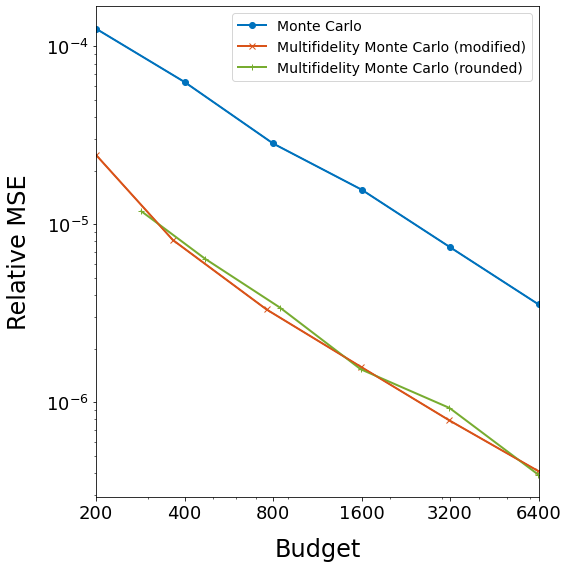

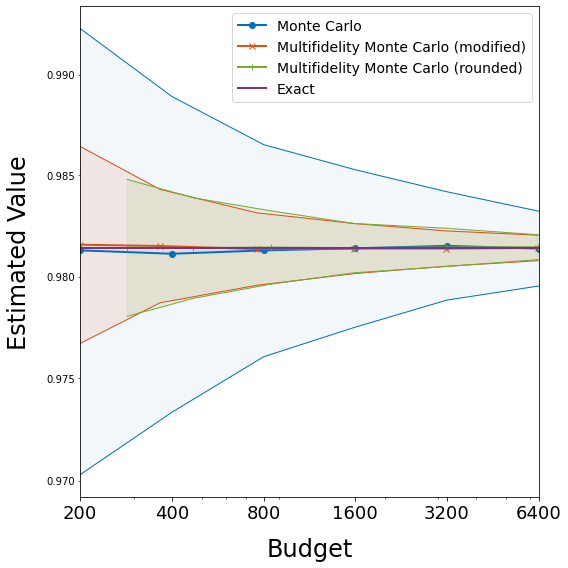

In [ ]:
# Estimate means and stdev
myMeanFOM = np.mean(yMeanFOM, axis=1)
myMean = np.mean(yMean, axis=1)
myMeanR = np.mean(yMeanR, axis=1)

yMeanStdFOM = np.std(yMeanFOM, axis=1, ddof=1)
yMeanStd = np.std(yMean, axis=1, ddof=1)
yMeanStdR = np.std(yMeanR, axis=1, ddof=1)
        
# estimate reference mean
number = int(1e+7)
yMeanRef = np.mean(modelList[0](drawSamples(number)))

# estimate MSE and relative MSE
mseMFMC = np.zeros(len(pList))
mseMFMCr = np.zeros(len(pList))
mseMC = np.zeros(len(pList))
abseMFMC = np.zeros(len(pList))
abseMFMCr = np.zeros(len(pList))
abseMC = np.zeros(len(pList))

for j in range(len(pList)):
    mseMFMC[j] = np.mean((yMeanRef - yMean[j])**2)
    mseMFMCr[j] = np.mean((yMeanRef - yMeanR[j])**2)
    mseMC[j] = np.mean((yMeanRef - yMeanFOM[j])**2)
    abseMFMC[j] = np.mean(np.abs(yMeanRef - yMean[j]))
    abseMFMCr[j] = np.mean(np.abs(yMeanRef - yMeanR[j]))
    abseMC[j] = np.mean(np.abs(yMeanRef - yMeanFOM[j]))

mseMFMC = np.mean((yMeanRef - yMean)**2, axis=1)
mseMFMCr = np.mean((yMeanRef - yMeanR)**2, axis=1)
mseMC = np.mean((yMeanRef - yMeanFOM)**2, axis=1)

varmseMFMC = np.var((yMeanRef - yMean)**2 / yMeanRef**2, axis=1)
varmseMFMCr = np.var((yMeanRef - yMeanR)**2 / yMeanRef**2, axis=1)
varmseMC = np.var((yMeanRef - yMeanFOM)**2 / yMeanRef**2, axis=1)

relmseMFMC = mseMFMC / yMeanRef**2
relmseMFMCr = mseMFMCr / yMeanRef**2
relmseMC = mseMC / yMeanRef**2

c1 = [0, 0.4470, 0.7410];
c2 = [0.8500, 0.3250, 0.0980];
c4 = [0.4940, 0.1840, 0.5560];
c3 = [0.4660, 0.6740, 0.1880];

temp = np.maximum(costs, costsR)
maxC = np.maximum(temp, costsFOM)
temp = np.minimum(costs, costsR)
minC = np.minimum(temp, costsFOM)

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('Budget', labelpad=15)
ax.set_ylabel('Relative MSE', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlim([minC[0],maxC[-1]])
# ax.set_xticks([minC[0], maxC[-1]])
ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
ax.set_xticks([200,400,800,1600,3200,6400])
ax.plot(costsFOM, relmseMC, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, relmseMFMC, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo (modified)')
ax.plot(costsR, relmseMFMCr, '-+', color=c3, linewidth=2, label='Multifidelity Monte Carlo (rounded)')
x=costsFOM
curve1 = relmseMC + varmseMC
curve2 = relmseMC - varmseMC
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = relmseMFMC + varmseMFMC
curve2 = relmseMFMC - varmseMFMC
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
x=costsR
curve1 = relmseMFMCr + varmseMFMCr
curve2 = relmseMFMCr - varmseMFMCr
# ax.plot(x, curve1, color=c3, linewidth=1)
# ax.plot(x, curve2, color=c3, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
# ax.fill(x2, inBetween, color=c3, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
plt.savefig('mse.png', transparent=True)
plt.show()

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('Budget', labelpad=15)
ax.set_ylabel('Estimated Value', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlim([minC[0], maxC[-1]])
ax.set_xticks([200,400,800,1600,3200,6400])
# ax.set_ylim([0.98715,0.98735])
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.yaxis.label.set_size(24)
# ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
# ax.ticklabel_format(useOffset=False, axis='x', style='plain')
# ax.set_xticks([minC[0],maxC[-1]])
# plt.rc('font', size=18)
ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
# for tick in ax.xaxis.get_majorticklabels():
#     tick.set_horizontalalignment("left")
ax.plot(costsFOM, myMeanFOM, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, myMean, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo (modified)')
ax.plot(costsR, myMeanR, '-+', color=c3, linewidth=2, label='Multifidelity Monte Carlo (rounded)')
ax.plot(costsFOM, [yMeanRef for i in range(6)], '-', color=c4, linewidth=2, label='Exact')
x=costsFOM
curve1 = myMeanFOM + yMeanStdFOM
curve2 = myMeanFOM - yMeanStdFOM
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate((x, x[::-1]), axis=0)
inBetween = np.concatenate((curve1, curve2[::-1]), axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = myMean + yMeanStd
curve2 = myMean - yMeanStd
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
x=costsR
curve1 = myMeanR + yMeanStdR
curve2 = myMeanR - yMeanStdR
ax.plot(x, curve1, color=c3, linewidth=1)
ax.plot(x, curve2, color=c3, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c3, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14}, loc=1)
plt.tight_layout()
plt.savefig('value.png', transparent=True)
plt.show()

In [ ]:
pList = w[0]*np.array([2**k for k in range(1,7)])

for (j,p) in enumerate(pList):  #compute estimate for different budgets
    # compute optimal number of model evals/coefficients
    Mlevel, coeff, v = optiMlevelCorr(X, w, p, 1)
    print(f'Number of model evals MFMC is {Mlevel} and budget is {p/w[0]}')
    
for (j,p) in enumerate(pList):  #compute estimate for different budgets
    # compute optimal number of model evals/coefficients
    MlevelR, coeffR, vR = optiMlevelCorr(X, w, p, 0)
    print(f'Number of model evals MFMCR is {MlevelR} and budget is {p/w[0]}')

Number of model evals MFMC is [ 1  1 10] and budget is 2.0
Number of model evals MFMC is [ 1  1 43] and budget is 4.0
Number of model evals MFMC is [  1   3 102] and budget is 8.0
Number of model evals MFMC is [  1   8 218] and budget is 16.0
Number of model evals MFMC is [  2  16 437] and budget is 32.0
Number of model evals MFMC is [  4  32 875] and budget is 64.0
Number of model evals MFMCR is [ 1  1 27] and budget is 2.0
Number of model evals MFMCR is [ 1  2 54] and budget is 4.0
Number of model evals MFMCR is [  1   4 109] and budget is 8.0
Number of model evals MFMCR is [  1   8 218] and budget is 16.0
Number of model evals MFMCR is [  2  16 437] and budget is 32.0
Number of model evals MFMCR is [  4  32 875] and budget is 64.0
